# Neural network classification 

### data

In [168]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

In [169]:
N_SAMPLES = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X, y = make_circles(N_SAMPLES,
                    noise=0.04,
                    random_state=42)

X, y = torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)

from sklearn.model_selection import train_test_split
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=TEST_SIZE,
                                                   random_state=42)

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)
print(len(X_train), len(X_test))

800 200


In [170]:
circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                        "y" : y})
circles

,X1,X2,y
0,0.748227,0.239083,1.0
1,-0.745096,0.160975,1.0
2,-0.822625,0.197621,1.0
3,-0.411433,0.682556,1.0
4,0.443905,-0.895829,0.0
...,...,...,...
995,0.246572,0.934956,0.0
996,-0.982012,-0.280268,0.0
997,-0.132565,-0.818072,1.0
998,0.665633,-0.780346,0.0


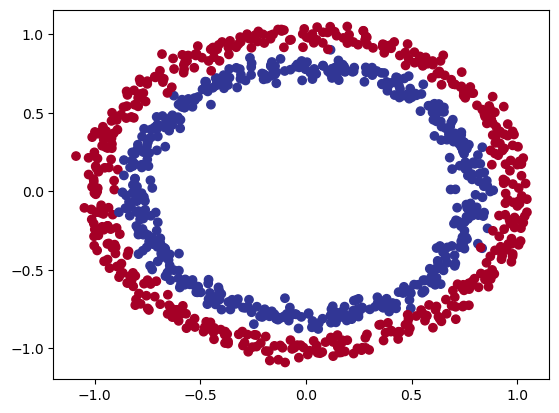

In [171]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)
plt.show()

In [172]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

### building a model

In [173]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=16)
        self.layer2 = nn.Linear(in_features=16, out_features=1)
    
    def forward(self, x):
        return self.layer2(self.layer1(x))
    
model = CircleModel().to(device)
model, next(model.parameters()).device

(CircleModel(
   (layer1): Linear(in_features=2, out_features=16, bias=True)
   (layer2): Linear(in_features=16, out_features=1, bias=True)
 ),
 device(type='cuda', index=0))

In [174]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=1)
).to(device)

model, next(model.parameters()).device

(Sequential(
   (0): Linear(in_features=2, out_features=16, bias=True)
   (1): ReLU()
   (2): Linear(in_features=16, out_features=1, bias=True)
 ),
 device(type='cuda', index=0))

In [175]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1473,  0.5865],
                      [-0.4191, -0.4217],
                      [-0.4217,  0.6360],
                      [ 0.2356,  0.6804],
                      [-0.5836, -0.7014],
                      [-0.5532, -0.4757],
                      [ 0.2864,  0.2532],
                      [ 0.5876, -0.3652],
                      [-0.4820,  0.3752],
                      [-0.2858,  0.4292],
                      [-0.1678,  0.4045],
                      [-0.5494, -0.3568],
                      [ 0.2156,  0.1495],
                      [-0.1803,  0.4215],
                      [ 0.4807, -0.5128],
                      [-0.3775,  0.6475]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2386, -0.2507, -0.6842, -0.4049,  0.1766, -0.0933, -0.5133,  0.0166,
                      -0.4830, -0.5999, -0.3894, -0.6189, -0.4502,  0.7068,  0.1336,  0.2179],
                     device='cuda:0')),
             ('2.weight',
   

In [176]:
with torch.inference_mode():
    y_logits = model(X_test)
    
print(len(y_logits), y_logits.shape)

200 torch.Size([200, 1])


In [177]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.05)

In [178]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### train model

In [179]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs = torch.round(y_pred_probs)
print(y_pred_probs.squeeze())

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [180]:
y_pred_labels = torch.round(torch.sigmoid(model(X_test)))
y_pred_labels.squeeze()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [181]:
torch.manual_seed(42)
epochs = 5000
for epoch in range(epochs):
    model.train() #training
    
    y_logits = model(X_train).squeeze() #forward pass 
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, #calculate loss
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred) 
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits,
                             y_test)
        test_acc = accuracy_fn(y_true=y_test, 
                               y_pred=test_pred)
        
        if epoch % 10 == 0:
            print(f"{epoch} | {loss} | {acc}")
    
    

0 | 0.692424476146698 | 50.0
10 | 0.6904048919677734 | 57.375
20 | 0.6889746189117432 | 51.125
30 | 0.6879028677940369 | 51.37500000000001


40 | 0.6870426535606384 | 52.125
50 | 0.6863154172897339 | 52.37500000000001
60 | 0.6856693625450134 | 52.75
70 | 0.6850714087486267 | 52.625
80 | 0.6845055818557739 | 52.625
90 | 0.6839622855186462 | 53.0
100 | 0.6834306120872498 | 52.75
110 | 0.6829087734222412 | 52.625
120 | 0.6823967099189758 | 53.125
130 | 0.6818867325782776 | 53.37499999999999
140 | 0.6813738942146301 | 53.625
150 | 0.680854082107544 | 53.75
160 | 0.6803309321403503 | 54.0
170 | 0.6798086166381836 | 55.125
180 | 0.6792832612991333 | 55.75
190 | 0.678752064704895 | 56.25
200 | 0.6782201528549194 | 57.25
210 | 0.6776886582374573 | 58.5
220 | 0.6771692037582397 | 60.62499999999999
230 | 0.6766537427902222 | 61.75000000000001
240 | 0.6761393547058105 | 62.25000000000001
250 | 0.6756225228309631 | 62.74999999999999
260 | 0.6751055121421814 | 63.375
270 | 0.6745853424072266 | 64.125
280 | 0.6740593314170837 | 65.125
290 | 0.6735323071479797 | 65.5
300 | 0.6730015277862549 | 66.5
310 | 0.6724684238433838 | 67.0
320 | 0.

In [182]:
import requests 
from pathlib import Path

if Path("helper_function.py").is_file():
    print("file already exists")
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open('helper_functions.py', 'wb') as file:
        file.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

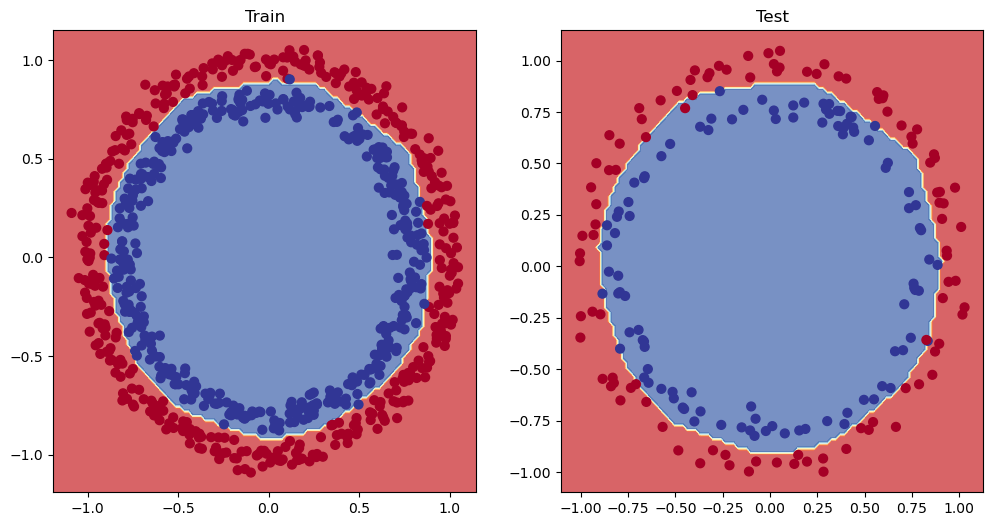

In [183]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)